# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod




## 1. Implementing ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [1410]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
    
    #Input type and value check              
        if not isinstance(narms,int):
            raise TypeError("narms should be int")
        elif narms < 0:
            raise ValueError("narms should be 0 or positive")
            
        if not isinstance(epsilon,float):
            raise TypeError("epsilon should be float")
        elif  epsilon < 0 or epsilon > 1:
            raise ValueError("epsilon should be between 0 and 1")
        
        if not isinstance(Q0,float):
            raise TypeError("Q0 should be float")        
              
    #Initialisation of variables 
        self.epsilon = epsilon 
        self.narms = narms
        self.Q0 =Q0   
        self.arm_count = np.zeros(narms) 
        self.q_value = np.repeat(self.Q0,narms) ### Initialize Qvalues with Q0 infinity
        self.reward = np.zeros(narms)
        
    def play(self, tround, context=None):   
    #Select an arm to play based on epsilon value- Explore,Exploit 
    
            e = np.random.rand() 
            if e < self.epsilon:
                arm = np.random.randint(self.narms) # Select random arm if e < epsilon-Explore!
               
            else:
                max_arm = np.argwhere(self.q_value == np.amax(self.q_value))  #Select arm with max expected reward-Exploit!         
                arm = np.random.choice(max_arm.flatten().tolist())
                
            return arm
        
        
    def update(self, arm, reward, context=None):      
    #If arm is matched with log file-update reward,count and qvalue of the arm
    
        self.reward[arm] = self.reward[arm] + reward  
        self.arm_count[arm] += 1 
        self.q_value[arm] = self.reward[arm]/(self.arm_count[arm]) 
       
        
        



In [1705]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
      
    #Input type and value check
        if not isinstance(narms,int):
            raise TypeError("narms should be int")
        elif narms < 0:
            raise ValueError("narms should be 0 or positive")
            
        if not isinstance(rho,float):
            raise TypeError("rho should be float")
        elif  rho <= 0:
            raise ValueError("rho should be positive real")
        
        if not isinstance(Q0,float):
            raise TypeError("Q0 should be float")
  
    #Initialisation of variables
        self.narms = narms
        self.rho = rho
        self.Q0 =Q0
        self.arm_count = np.zeros(self.narms)
        self.q_value =  np.repeat(Q0,self.narms)
        self.mean= np.zeros(self.narms)
        self.reward = np.zeros(self.narms)
          
        
    def play(self, tround, context=None):     
      #Calculate qvalue for each arm and play arm with max qvalue   

        for arm in range(self.narms):
            
            if self.arm_count[arm] > 0:
                self.mean[arm] = self.reward[arm]/(self.arm_count[arm]) #Expected rewards of each arm-used to exploit
                explore_boost = np.sqrt(self.rho*np.log(tround)/self.arm_count[arm]) #Explore boost- used to explore
                self.q_value[arm] = self.mean[arm] + explore_boost #Balance between explore and exploit for each arm 
            else:
                self.q_value[arm] = self.Q0 #use Q0 until arm has been pulled
        
        #Explore those arms with max explore boost, Exploit arms with max rewards
        max_arm = np.argwhere(self.q_value == np.amax(self.q_value))  
        arm = np.random.choice(max_arm.flatten().tolist())      
        return arm
    
    
    def update(self, arm, reward, context=None):        
     #Update reward and count of matched arm

        self.reward[arm] = self.reward[arm]+reward
        self.arm_count[arm] += 1 
        
                 
        
        
        

    

## 2. The Basic Thompson Bandit

In [1703]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        
    #Input type and value check   
        if not isinstance(narms,int):
            raise TypeError("narms should be int")
        elif narms < 0:
            raise ValueError("narms should be 0 or positive")
            
        if not isinstance(alpha0,float): 
            raise TypeError("alpha0 should be float")
        elif   alpha0 <= 0:
            raise ValueError("alpha0 should be positive real")
            
        if not isinstance(beta0,float): 
            raise TypeError("beta0 should be float")
        elif   beta0 <= 0:
            raise ValueError("beta0 should be positive real")

    #Initialisation of parameters
        self.alpha = alpha0
        self.beta = beta0
        self.narms = narms
        self.success = np.zeros(self.narms)
        self.failure = np.zeros(self.narms)
                        
    
    def play(self, tround, context=None):
        
    ## Play an arm with max prior beta probability
            thetas = []
            for arm in range(self.narms):
                theta = np.random.beta(self.success[arm]+self.alpha,self.failure[arm]+self.beta) # Randomly sample means from prior beta for each arm
                thetas.append(theta)
            max_theta = np.amax(thetas) 
            max_arm = np.argwhere(thetas == max_theta) #Select arm with max prior probability
            
            #Randomly choosing between arms with maximum prior probability
            max_arm = np.random.choice(max_arm.flatten().tolist()) 
 
            return max_arm

    def update(self, arm, reward, context=None):
        
    #Update posterior probability based on reward
        if reward == 1:
            self.success[arm] += 1
        else:
            self.failure[arm] += 1

    


    

## 3. Off-Policy Evaluation

In [1684]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """ 
    
#Input type check
    if  not isinstance(mab,(EpsGreedy,UCB,BetaThompson,LinUCB,LinThompson)): 
        raise TypeError("mab does not belong to EpsGreedy, UCB, BetaThompson, LinUCB or LinThompson")

    if not isinstance(arms,np.ndarray) and not arms.ndim == 1:
        raise TypeError("arms is not 1D array")

    
    if not isinstance(rewards,np.ndarray) and not rewards.ndim == 1:
        raise TypeError("rewards is not 1D array")

            
    if not isinstance(contexts,np.ndarray) and not contexts.ndim == 2:
        raise TypeError("contexts is not 2D array")

#Initialisation of variables
    history = [] 
    index = 0
    nevents = len(arms)
    
    for t in range(nrounds) :      
        t_1 = len(history) + 1   #Call bandit with t-1 rounds
        while(index < nevents): #Iterate until arm is matched
            
            bandit_arm = mab.play(t_1,contexts[index].reshape((contexts.shape[1],1))) #Play arm from bandit
            
            if bandit_arm+1 == arms[index]: #Check if bandit arm equals log file arm; bandit_arm+1 because arm should be positive int  
                break                       #if true-Update history
            index += 1                      #if false-get next event of log file
        mab.update(bandit_arm,rewards[index],contexts[index].reshape((contexts.shape[1],1)))
        history.append((t_1,arms[index],rewards[index],contexts[index])) 
        index += 1        #If match occurs, break while loop and get next event of log file
  
    results = [reward for _,_,reward,_ in history] #evaluate the rewards of the bandits
    
    return results 

In [1674]:
#Read log file to evaluate bandits
arms =   np.loadtxt(r"C:\Users\maria\Desktop\ML\Project 2\dataset.txt",usecols=0,dtype=int,ndmin=1)
rewards = np.loadtxt(r"C:\Users\maria\Desktop\ML\Project 2\dataset.txt",usecols=1,dtype=float,ndmin=1)
contexts = np.loadtxt(r"C:\Users\maria\Desktop\ML\Project 2\dataset.txt",usecols=np.arange(2,102),dtype=float,ndmin=2)

In [1675]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.26375


In [1706]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.1625


In [1630]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.19


## 4. Contextual Bandits - LinUCB

In [1692]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        
    #Input type and value check    
        if not isinstance(narms,int):
            raise TypeError("narms should be int")
        elif narms < 0:
            raise ValueError("narms should be 0 or positive")
            
        if not isinstance(ndims,int):
            raise TypeError("ndims should be int")
        elif narms < 0:
            raise ValueError("ndims should be 0 or positive")
            
        if not isinstance(alpha,float): 
            raise TypeError("alpha should be float")
        elif   alpha <= 0:
            raise ValueError("alpha should be positive real")
            
    #Initialization of variables
        self.alpha=alpha
        self.narms =  narms
        self.ndims = ndims 
        self.A  = np.zeros((narms, ndims,ndims)) #Initializing d by d matrix for contexts-A
        self.b = np.zeros((narms, ndims,1)) #Initializing response vector for each arm with dim-d by 1
        self.lin_Ucb = np.zeros(narms)
        self.visited = []

    def play(self, tround, context):    
      #play arm with maximum linear estimate and explore boost value including contexts 

            for arm in range(self.narms):      
                if arm not in self.visited:   #Set the context of each new arm to indentity matrix          
                    
                    self.A[arm] = np.identity(self.ndims)           
                    self.visited.append(arm)
                
                context_arm = context[0+(arm*self.ndims):self.ndims+(arm*self.ndims)] #Extract context based on arm            
       
                A_Invere = np.linalg.inv(self.A[arm]) 
                theta = A_Inverse.dot(self.b[arm]) #Calculate Parameter value of arm
                
                lin_estimate = np.transpose(theta).dot(context_arm) #Estimate linear combination of parameters;
                explore_boost = self.alpha * np.sqrt(np.transpose(context_arm).dot(A_Inverse).dot(context_arm)) #Explore based on explore_boost
                self.lin_Ucb[arm] = lin_estimate + explore_boost #UCB; balance between explore and exploit using contexts 
         
        #play arm with max linear ucb, if arm has minimum expected return but higher explore boost,it is selected for play
            max_arm = np.argwhere(self.lin_Ucb == np.amax(self.lin_Ucb))        
            arm = np.random.choice(max_arm.flatten().tolist())
            return arm
        
    def update(self, arm, reward, context):
    #Update the context and expected reward of the matched arm
        context_played_arm = context[0+(arm*self.ndims):self.ndims+(arm*self.ndims)]
        self.A[arm] = self.A[arm] + context_played_arm.dot(np.transpose(context_played_arm)) #Update feature matrix
        self.b[arm] = self.b[arm] + reward*context_played_arm   #Update response vector
        



In [1693]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts,800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 5. Contextual Bandits - LinThompson

In [1699]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        
     #Input type and value check    
        if not isinstance(narms,int):
            raise TypeError("narms should be int")
        elif narms < 0:
            raise ValueError("narms should be 0 or positive")
            
        if not isinstance(ndims,int):
            raise TypeError("ndims should be int")
        elif narms < 0:
            raise ValueError("ndims should be 0 or positive")
            
        if not isinstance(v,float): 
            raise TypeError("v should be float")
        elif   v <= 0:
            raise ValueError("v should be positive real")
            
    #Initialisation of variables
        self.narms=narms
        self.ndims=ndims
        self.B= np.identity(ndims) #Covariance matrix for multivariate normal-ndims by ndims
        self.mu_hat = np.zeros(narms) #Mean vector for multivariate normal-ndims
        self.f = np.zeros(narms)
        self.v=v
        self.linear_estimation = np.zeros(narms)
            
        
    def play(self, tround, context):    
    #Play arm with maximum linear estimate using normal distribution as prior
    
            # Prior for Sample mean from multivariate Gaussian likelihood
            mu_estimation = np.random.multivariate_normal(self.mu_hat,(self.v**2)*np.linalg.inv(self.B)) 
                    
            for arm in range(self.narms):
                #Extract arm context for the round t-1
                context_arm= context[0+(arm*self.ndims):self.ndims+(arm*self.ndims)] 
                
                mu_estimation = mu_estimation.reshape(self.ndims,1)
                
                #Linear estimation of parameters for arms using mvn mean
                self.linear_estimation[arm] = np.transpose(context_arm).dot(mu_estimation)

           #Max arm based on linear estimation of parameters
            max_arm = np.argwhere(self.linear_estimation == np.amax(self.linear_estimation))             
            arm = np.random.choice(max_arm.flatten().tolist())
            return arm
    
    def update(self, arm, reward, context):
    #Update covariance and mean for matched arm
    
        context_played = context[0+(arm*self.ndims):self.ndims+(arm*self.ndims)]
        self.B=self.B+context_played.dot(np.transpose(context_played)) #upate covariance matrix with context of matched arm
        self.f = self.f.reshape(self.ndims,1)
        self.f=self.f+context_played*reward #response vector  
        self.mu_hat = np.linalg.inv(self.B).dot(self.f) #Update posterior Gaussian with matched arm's reward and context
        self.mu_hat=self.mu_hat.flatten()   #Flat the array since mvn expects a 1D mean vector
       
        
        


In [1700]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.32625


## 6. Evaluation
### 6.A.

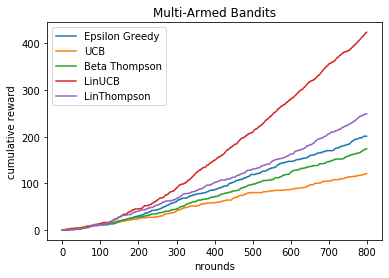

From the plot it can be seen that LinUCB has the highest expected reward, followed by LinThompson. Hence, features are substantial in playing an arm. For context-free bandits, Beta Thompson has the highest  expected reward compared to UCB and Epsilon Greedy


In [1716]:
#Plot for bandits- cumulative reward vs nrounds

#1.Epsilon Greedy
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
plt.plot(np.cumsum(results_EpsGreedy),label='Epsilon Greedy')

#2.UCB
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
plt.plot(np.cumsum(results_UCB),label='UCB')

#3.Beta Thompson
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
plt.plot(np.cumsum(results_BetaThompson),label='Beta Thompson')

#4.Linear UCB
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts,800)
plt.plot(np.cumsum(results_LinUCB),label='LinUCB')

#5.Linear Thompson
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
plt.plot(np.cumsum(results_LinThompson),label='LinThompson')

plt.legend()
plt.ylabel('cumulative reward')
plt.xlabel('nrounds')
plt.title('Multi-Armed Bandits')
plt.show()

Comment = """From the plot it can be seen that LinUCB has the highest expected reward, followed by LinThompson.\
 Hence, features are substantial in playing an arm. For context-free bandits, Beta Thompson has the highest \
 expected reward compared to UCB and Epsilon Greedy"""

print(Comment)
    







### 6.B.

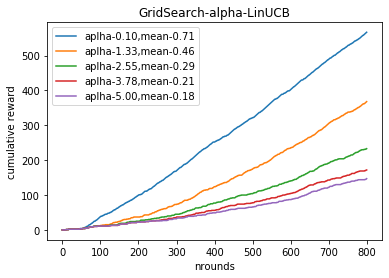

In LinUCB, it can be seen that, smaller the alpha value greater is the expected reward


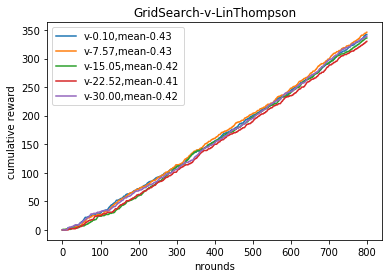

In LinThompson, it can be seen that,value of V does not have a substantial impact on the expected reward


In [1714]:
a = np.linspace(0.1, 5.0, num=5)
for i in range(len(a)):
    mab = LinUCB(10, 10,a[i] )
    results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts,800)
    plt.plot(np.cumsum(results_LinUCB),label='aplha-%.2f,mean-%.2f'%(a[i],np.mean(results_LinUCB)))
    
plt.ylabel('cumulative reward')
plt.xlabel('nrounds')
plt.title('GridSearch-alpha-LinUCB')   
plt.legend()
plt.show()

print("In LinUCB, it can be seen that smaller the alpha value greater is the expected reward")

a = np.linspace(0.1, 30, num=5)
for i in range(len(a)):
    mab = LinThompson(10, 10, 0.1)
    results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
    plt.plot(np.cumsum(results_LinThompson),label='v-%.2f,mean-%.2f'%(a[i],np.mean(results_LinThompson)))
    
plt.ylabel('cumulative reward')
plt.xlabel('nrounds')
plt.title('GridSearch-v-LinThompson')   
plt.legend()
plt.show()

print("In LinThompson, it can be seen that value of V does not have a substantial impact on the expected reward")
